In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pathlib
from pathlib import Path
os.chdir("/content/drive/My Drive/Akarshan/BERT")
!ls -l

total 51350
-rw------- 1 root root  8388432 Dec 26 21:48  BERT5.hdf5
drwx------ 2 root root     4096 Dec  3 16:27  clr
-rw------- 1 root root   488058 Dec 25 21:03  Compare.ipynb
-rw------- 1 root root   258091 Dec 26 21:52 'Copy of Distllbert400000.ipynb'
-rw------- 1 root root    76810 Dec 26 21:53 'Copy of Roberta.ipynb'
drwx------ 2 root root     4096 Dec  3 16:27  Data
-rw------- 1 root root  8306584 Dec 24 07:57  DBert1hk.hdf5
-rw------- 1 root root 12719136 Dec 24 07:57  DBert4hk.hdf5
-rw------- 1 root root   251068 Dec 26 21:28  Distllbert400000.ipynb
-rw------- 1 root root   476335 Dec 26 21:08 'EDA on results.ipynb'
drwx------ 2 root root     4096 Dec 18 07:14 'misc model'
-rw------- 1 root root    78553 Dec 26 21:47  model.png
drwx------ 2 root root     4096 Dec  3 16:27  papers
-rw------- 1 root root  8306584 Dec 19 08:56  Rbert4.hdf5
-rw------- 1 root root   203164 Dec 26 21:29  Retraining.ipynb
-rw------- 1 root root    86347 Dec 19 06:43  Roberta.ipynb
-rw------- 1 root 

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec 26 21:54:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers
!pip install pympler
!pip install tensorflow_addons

     |████████████████████████████████| 3.4 MB 4.1 MB/s 
     |████████████████████████████████| 596 kB 92.1 MB/s 
     |████████████████████████████████| 3.3 MB 65.0 MB/s 
     |████████████████████████████████| 895 kB 90.4 MB/s 
     |████████████████████████████████| 61 kB 673 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 164 kB 4.1 MB/s 
     |████████████████████████████████| 1.1 MB 4.3 MB/s 


In [ ]:
import numpy as np
import pickle
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
from pympler import asizeof
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import pipeline
from tensorflow.keras.layers import concatenate
from transformers import TFAutoModel, AutoTokenizer, AutoConfig,TFAutoModelForSequenceClassification
from tensorflow.keras.callbacks import ModelCheckpoint
from clr import clr_callback
import tensorflow_addons as tfa

In [ ]:
csvfile = 'Data//data.csv'
dropna = 'Data//datadropna.csv'
sent_data_file = 'Data//sent_data.csv'
label_file = 'Data//label.csv'
vocab_file = 'Data//vocab_tr_w.txt'

In [ ]:
df = pd.read_csv(dropna,usecols = ['SBE','Label'])
# df.dropna(inplace=True)
print(df.head())
print(df.shape)

   Label                                                SBE
0      1  To facilitate an easier notation throughout th...
1      0  Therefore _MATH_ defines a special order of ti...
2      0  This is important since only _MATH_ is the rea...
3      0  Note that in all contour time-integrals we ess...
4      0  Theorem _REF_ proves the equivalence of ensemb...
(1189321, 2)


## Generating Embeddings

In [ ]:
# Hyperparameters form paper

epoch = 30
patience = 10
lr = 1e-6
batch_size = 32
vocab = 30526 #will have to retrain Bert so not using
MAX_LEN = 128 #not enough ram for 256

In [ ]:
model_name = 'roberta-base'
config = AutoConfig.from_pretrained(model_name,trianing =False, num_labels=2 )
config.output_hidden_states = False

BERT = TFAutoModel.from_pretrained(model_name,config = config)

tokenizer = AutoTokenizer.from_pretrained(model_name,
                                          do_lower_case=True, 
                                          use_fast=True,
                                          max_length=MAX_LEN,
                                          truncation=True,
                                          pad_to_max_length=True)

pipe = pipeline('feature-extraction', model=BERT, 
                tokenizer=tokenizer,device=1)


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
batch=500
df = df.iloc[300000:400000,:]
step = int(df.shape[0]/batch)
step

200

In [ ]:
#### getting embedding vectors as bert output ###
# pipe returns embeddings for every token in a sent 
# so features[x][0] is of shape (y,768) with y tokens in xth sentance
# taking the mean for y tokens give the embedding for the xth sent in total
# saving a batch of features as feature_matrix with 768 zeors as head 
import pickle
import time
count = 500+500+500
for part in range(batch):
  i = part+count
  strt = time.time()
  indx = step*part
  indy = step*(part+1)
  # print(indx,indy)
  feature_matrix = array = np.empty(768, dtype=object) 
  lst = []
  features = np.array(pipe(df['SBE'].iloc[indx:indy].to_list()))

  for idx in range(np.shape(features)[0]):
    sent_mean = np.mean(features[idx][0],axis =0)
    lst.append(sent_mean)
  # print(np.shape(lst))
  feature_matrix= np.array(lst)
  # print(np.shape(feature_matrix))
  # print(feature_matrix)
  
  with open('Data//embeddingRo//embeddings'+str(i),'wb') as f:
    pickle.dump(feature_matrix,f)
  
  print(f'Part {part+1} of {batch} done. in {(time.time()-strt)/60:.2f} min')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Part 1 of 500 done. in 1.18 min
Part 2 of 500 done. in 1.20 min
Part 3 of 500 done. in 1.22 min
Part 4 of 500 done. in 1.16 min
Part 5 of 500 done. in 1.22 min
Part 6 of 500 done. in 1.18 min
Part 7 of 500 done. in 1.32 min
Part 8 of 500 done. in 1.22 min
Part 9 of 500 done. in 1.24 min
Part 10 of 500 done. in 1.24 min
Part 11 of 500 done. in 1.23 min
Part 12 of 500 done. in 1.23 min
Part 13 of 500 done. in 1.21 min
Part 14 of 500 done. in 1.30 min
Part 15 of 500 done. in 1.31 min
Part 16 of 500 done. in 1.27 min
Part 17 of 500 done. in 1.23 min
Part 18 of 500 done. in 1.23 min
Part 19 of 500 done. in 1.16 min
Part 20 of 500 done. in 1.21 min
Part 21 of 500 done. in 1.22 min
Part 22 of 500 done. in 1.21 min
Part 23 of 500 done. in 1.25 min
Part 24 of 500 done. in 1.23 min
Part 25 of 500 done. in 1.23 min
Part 26 of 500 done. in 1.28 min
Part 27 of 500 done. in 1.26 min
Part 28 of 500 done. in 1.30 min
Part 29 of 500 done. in 1.25 min
Part 30 of 500 done. in 1.27 min
Part 31 of 500 done

In [ ]:
num = len(os.listdir('Data//embeddingRo//'))

with open('Data//embeddingRo//embeddings'+str(0),'rb') as f:
    dataD = pickle.load(f)
    
for idx in range(1,num):
    
  with open('Data//embeddingRo//embeddings'+str(idx),'rb') as f:
    mat = pickle.load(f)
    dataD=np.concatenate([dataD,mat],axis=0)

In [ ]:
np.shape(dataD)

(400000, 768)

In [ ]:
df = df.iloc[:400000,:]

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(dataD, df['Label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['Label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [ ]:
train_labels = tf.keras.utils.to_categorical(train_labels)
val_labels = tf.keras.utils.to_categorical(val_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((train_text, train_labels))
train_data = train_data.batch(128)


val_data = tf.data.Dataset.from_tensor_slices((val_text, val_labels))
val_data = val_data.batch(128)


In [ ]:
input = tf.keras.layers.Input(shape=(768,), name='input_token', dtype='int32')
X = tf.keras.layers.Dense(768, activation='relu')(input)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(512, activation='relu')(input)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(128, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(2, activation='softmax')(X)
model = tf.keras.Model(inputs=input, outputs = X)

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_token (InputLayer)    [(None, 768)]             0         
                                                                 
 dense_18 (Dense)            (None, 512)               393728    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 128)               65664     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 2)                 258       
                                                                 
Total params: 459,650
Trainable params: 459,650
Non-trainab

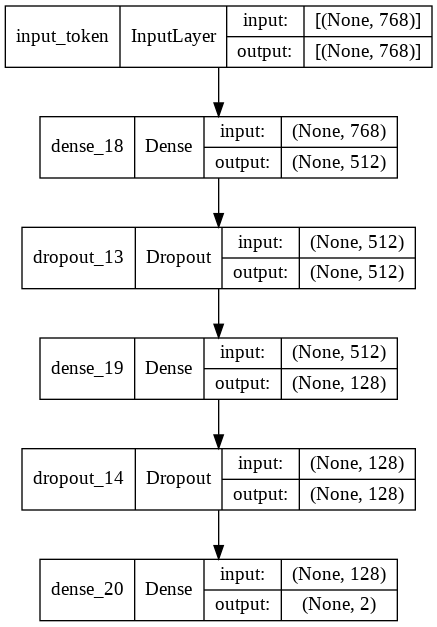

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
filepath="roBERT.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss',verbose=1,save_best_only=True, mode='min')
ES =tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=patience,verbose=1,mode="min",restore_best_weights=True)
# pre = tf.keras.metrics.Precision()
f1 = tfa.metrics.F1Score(num_classes=2, average="macro")
callbacks_list = [checkpoint,ES]
model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=[f1])

In [ ]:
history = model.fit(train_data, validation_data=val_data, epochs=epoch,verbose=1, callbacks = callbacks_list)

Epoch 1/30
2185/2188 [============================>.] - ETA: 0s - loss: 0.6529 - f1_score: 0.4582
Epoch 00001: val_loss improved from inf to 0.65063, saving model to roBERT.hdf5
2188/2188 [==============================] - 8s 4ms/step - loss: 0.6529 - f1_score: 0.4582 - val_loss: 0.6506 - val_f1_score: 0.4436
Epoch 2/30
2180/2188 [============================>.] - ETA: 0s - loss: 0.6506 - f1_score: 0.4540
Epoch 00002: val_loss improved from 0.65063 to 0.64889, saving model to roBERT.hdf5
2188/2188 [==============================] - 8s 4ms/step - loss: 0.6506 - f1_score: 0.4540 - val_loss: 0.6489 - val_f1_score: 0.4474
Epoch 3/30
2187/2188 [============================>.] - ETA: 0s - loss: 0.6502 - f1_score: 0.4530
Epoch 00003: val_loss improved from 0.64889 to 0.64838, saving model to roBERT.hdf5
2188/2188 [==============================] - 9s 4ms/step - loss: 0.6502 - f1_score: 0.4530 - val_loss: 0.6484 - val_f1_score: 0.4510
Epoch 4/30
2186/2188 [============================>.] - ETA

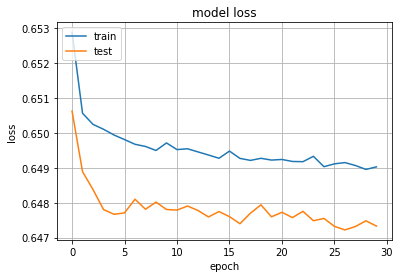

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.grid()
plt.show()

In [ ]:
from keras.models import load_model
model = load_model("roBERT.hdf5")

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices((test_text))
test_data = test_data.shuffle(5000).batch(128)

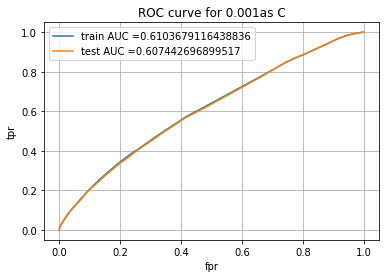

In [ ]:
y_pr_ts = model.predict(test_data)[:,0]
y_pred_tr = model.predict(train_data)[:,0]
y_ts = test_labels[:,0]
y_tr = train_labels[:,0]
from sklearn.metrics import roc_curve,auc,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

train_fpr, train_tpr, tr_thresholds = roc_curve(y_tr, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_ts, y_pr_ts)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (0.001)+'as C')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

print('train')
best_tr_thres = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

test
the maximum value of tpr*(1-fpr) 0.33247305148634676 for threshold 0.663
train
the maximum value of tpr*(1-fpr) 0.3344086594483335 for threshold 0.667


Train Confusion Matrix


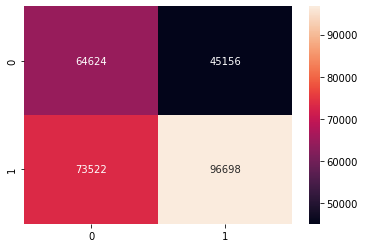

In [ ]:
print('Train Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_tr, predict_with_best_t(y_pred_tr, best_tr_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

Test Confusion Matrix


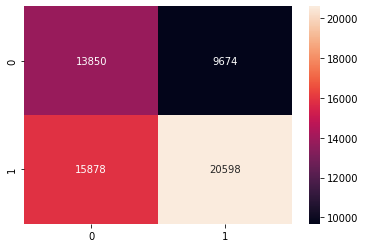

In [ ]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [ ]:
acc=accuracy_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100
ps=precision_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100
rc=recall_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100
f1=f1_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 57.41%
Precision on test set: 68.04%
recall score on test set: 56.47%
f1 score on test set: 61.72%


In [ ]:
acc=accuracy_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100
ps=precision_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100
rc=recall_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100
f1=f1_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 57.41%
Precision on test set: 68.04%
recall score on test set: 56.47%
f1 score on test set: 61.72%
